In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

In [2]:
train = pd.read_csv("train.csv") # 학습용 데이터
test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

## customer_country

In [3]:
train['customer_country_list'] = train['customer_country'].str.upper().str.split('/')
test['customer_country_list'] = test['customer_country'].str.upper().str.split('/')


# pip install pycountry
import pycountry

country_names = [country.name.upper()for country in pycountry.countries]

def find_country_name(country_list):
    if not isinstance(country_list, list):
        return 'X'
    for country in country_list:
        stripped_country = country.strip()
        if stripped_country in country_names:
            return stripped_country
    return 'X'

country_names.extend(['U.A.E','TURKEY','SOUTH KOREA','VIETNAM','TAIWAN', 'CZECH'])


train['in_country_names'] = train['customer_country_list'].apply(find_country_name)
test['in_country_names'] = test['customer_country_list'].apply(find_country_name)

train = train.drop(['customer_country','customer_country.1', 'customer_country_list'], axis = 1)
test = test.drop(['id','customer_country','customer_country.1', 'customer_country_list'], axis = 1)

## customer_idx

In [4]:
import pandas as pd


frequency = train['customer_idx'].value_counts()

# 빈도 기준 설정 (예: 100번 미만으로 등장하는 customer_idx)
threshold = 5

# 빈도가 낮은 customer_idx는 '기타'로 변경

train['customer_idx_grouped'] = train['customer_idx'].apply(lambda x: x if frequency[x] >= threshold else 'others')


frequency = test['customer_idx'].value_counts()
test['customer_idx_grouped'] = test['customer_idx'].apply(lambda x: x if frequency[x] >= threshold else 'others')




train = train.drop(['customer_idx'], axis = 1)
test = test.drop(['customer_idx'], axis = 1)


## com_reg_ver_win_rate

In [5]:
# !pip install pycountry_convert
import pycountry_convert as pc
import pycountry

country_names = [country.name.upper()for country in pycountry.countries]

def get_continent(country_name):
    try:
        # 국가 이름을 적절한 형식으로 변환 (예: 'INDIA' -> 'India')
        country_name_corrected = country_name.title()
        country_code = pc.country_name_to_country_alpha2(country_name_corrected)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except Exception as e:
        if country_name == 'U.A.E':
            return 'Asia'
        elif country_name == 'CZECH':
            return 'Europe'
        elif country_name == 'ANTIGUA AND BARBUDA':
            return 'North America'
        elif country_name == 'TRINIDAD AND TOBAGO':
            return 'North America'
        elif country_name == 'TURKS AND CAICOS ISLANDS':
            return 'North America'
        elif country_name == 'SAINT KITTS AND NEVIS':
            return 'North America'
        elif country_name == 'BOSNIA AND HERZEGOVINA':
            return 'Europe'
        elif country_name == 'ISLE OF MAN':
            return 'Europe'
            
        return 'X'

# 함수 적용
train['continent'] = train['in_country_names'].apply(get_continent)
test['continent'] = test['in_country_names'].apply(get_continent)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

train_crvwr = train[['business_unit', 'com_reg_ver_win_rate','in_country_names', 'continent']]
test_crvwr = test[['business_unit', 'com_reg_ver_win_rate','in_country_names', 'continent']]


qual_col = ['business_unit', 'in_country_names', 'continent']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_crvwr[i])
    train_crvwr[i] = le.transform(train_crvwr[i])
    
    for label in np.unique(test_crvwr[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_crvwr[i] = le.transform(test_crvwr[i]) 

print('Done.')


labeled_data = train_crvwr[train_crvwr['com_reg_ver_win_rate'].notna()]
unlabeled_data = train_crvwr[train_crvwr['com_reg_ver_win_rate'].isna()]


model = LinearRegression()
model.fit(labeled_data[['business_unit', 'in_country_names', 'continent']], labeled_data['com_reg_ver_win_rate'])


unlabeled_data['com_reg_ver_win_rate'] = model.predict(unlabeled_data[['business_unit', 'in_country_names', 'continent']])

# 레이블이 없는 데이터에 대한 예측값을 새로운 타겟으로 사용
combined_data = pd.concat([
    labeled_data,
    unlabeled_data
 ])

# train에게 값 넣기
train['com_reg_ver_win_rate'] =combined_data['com_reg_ver_win_rate']

# 결합된 데이터셋으로 모델 재학습
model.fit(combined_data[['business_unit', 'in_country_names', 'continent']], combined_data['com_reg_ver_win_rate'])



# 모델로 test에 넣기

labeled_data = test_crvwr[test_crvwr['com_reg_ver_win_rate'].notna()]
unlabeled_data = test_crvwr[test_crvwr['com_reg_ver_win_rate'].isna()]

unlabeled_data['com_reg_ver_win_rate'] = model.predict(unlabeled_data[['business_unit', 'in_country_names', 'continent']])

combined_data = pd.concat([
    labeled_data,
    unlabeled_data
 ])

# test에 값 넣기
test['com_reg_ver_win_rate'] =combined_data['com_reg_ver_win_rate']

Done.


## customer_type

In [7]:
import re

train['customer_type'] = train['customer_type'].fillna('ETC')
test['customer_type'] = test['customer_type'].fillna('ETC')


cust_type = train['customer_type'].str.upper()
cust_type= cust_type.str.replace('-', ' ').str.replace('/', ' ').str.replace(r'\s+', ' ', regex=True)
cust_type[cust_type == 'OTHER'] = "ETC"

frequency = cust_type.value_counts()
threshold = 10
train['customer_type_grouped'] = cust_type.apply(lambda x: x if frequency[x] >= threshold else 'ETC')



cust_type = test['customer_type'].str.upper()
cust_type= cust_type.str.replace('-', ' ').str.replace('/', ' ').str.replace(r'\s+', ' ', regex=True)
cust_type[cust_type == 'OTHER'] = "ETC"

frequency = cust_type.value_counts()
threshold = 5
test['customer_type_grouped'] = cust_type.apply(lambda x: x if frequency[x] >= threshold else 'ETC')


train = train.drop(['customer_type'], axis = 1)
test = test.drop(['customer_type'], axis = 1)

## lead_desc_length

In [8]:
quantiles = train['lead_desc_length'].quantile([0.25, 0.75])
bins = [0, quantiles[0.25], quantiles[0.75], train['lead_desc_length'].max()]

labels = ['short', 'medium', 'long']
train['length_category'] = pd.cut(train['lead_desc_length'], bins=bins, labels=labels, include_lowest=True)

test['length_category'] = pd.cut(test['lead_desc_length'], bins=bins, labels=labels, include_lowest=True)



train = train.drop(['lead_desc_length'], axis = 1)
test = test.drop(['lead_desc_length'], axis = 1)

## inquiry_type


In [9]:
train['inquiry_type'] = train['inquiry_type'].fillna('other')
test['inquiry_type'] = test['inquiry_type'].fillna('other')



inquiry = train.inquiry_type.str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = inquiry.value_counts()
threshold = 30
train['inquiry_type_grouped'] = inquiry.apply(lambda x: x if frequency[x] >= threshold else 'ETC')


inquiry = test.inquiry_type.str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = inquiry.value_counts()
threshold = 30
test['inquiry_type_grouped'] = inquiry.apply(lambda x: x if frequency[x] >= threshold else 'ETC')


consolidated_categories = {
    'OTHERS': 'OTHER/ETC',
    'OTHER': 'OTHER/ETC',
    'OTHER ': 'OTHER/ETC',
    'ETC': 'OTHER/ETC',
    'ETC.': 'OTHER/ETC'
    
}

train['inquiry_type_grouped'] = train['inquiry_type_grouped'].replace(consolidated_categories)
test['inquiry_type_grouped'] = test['inquiry_type_grouped'].replace(consolidated_categories)


train = train.drop(['inquiry_type'], axis = 1)
test = test.drop(['inquiry_type'], axis = 1)


## customer_position

In [10]:
inquiry = train.customer_position.str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = inquiry.value_counts()
threshold = 30
train['customer_position_grouped'] = inquiry.apply(lambda x: x if frequency[x] >= threshold else 'ETC')


inquiry = test.customer_position.str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = inquiry.value_counts()
threshold = 30
test['customer_position_grouped'] = inquiry.apply(lambda x: x if frequency[x] >= threshold else 'ETC')




consolidated_categories = {
    'OTHERS': 'OTHER/ETC',
    'OTHER': 'OTHER/ETC',
    'OTHER ': 'OTHER/ETC',
    'ETC': 'OTHER/ETC',
    'ETC.': 'OTHER/ETC'
    
}

train['customer_position_grouped'] = train['customer_position_grouped'].replace(consolidated_categories)
test['customer_position_grouped'] = test['customer_position_grouped'].replace(consolidated_categories)

train = train.drop(['customer_position'], axis = 1)
test = test.drop(['customer_position'], axis = 1)


## lead_owner

In [11]:
lead_owner = train['lead_owner']
frequency = train.lead_owner.value_counts()
threshold = 20
train['lead_owenr_grouped'] = lead_owner.apply(lambda x: x if frequency[x] >= threshold else 'ETC')

lead_owner = test['lead_owner']
frequency = test.lead_owner.value_counts()
threshold = 5
test['lead_owenr_grouped'] = lead_owner.apply(lambda x: x if frequency[x] >= threshold else 'ETC')


train = train.drop(['lead_owner'], axis = 1)
test = test.drop(['lead_owner'], axis = 1)

## product_category

In [12]:

train['product_category'] = train.product_category.fillna('X')
test['product_category'] =test.product_category.fillna('X')

product_category = train['product_category'].str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = product_category.value_counts()
threshold = 50
train['product_category_grouped'] = product_category.apply(lambda x: x if frequency[x] >= threshold else 'ETC')



product_category = test['product_category'].str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = product_category.value_counts()
threshold = 5
test['product_category_grouped'] = product_category.apply(lambda x: x if frequency[x] >= threshold else 'ETC')


consolidated_categories = {
    'OTHERS': 'OTHER/ETC',
    'OTHER': 'OTHER/ETC',
    'OTHER ': 'OTHER/ETC',
    'ETC': 'OTHER/ETC',
    'ETC.': 'OTHER/ETC'
    
}

train['product_category_grouped'] = train['product_category_grouped'].replace(consolidated_categories)
test['product_category_grouped'] = test['product_category_grouped'].replace(consolidated_categories)


train = train.drop(['product_category'], axis = 1)
test = test.drop(['product_category'], axis = 1)


## expected_timeline

In [13]:
train['expected_timeline'] = train.expected_timeline.fillna('X')
test['expected_timeline'] =test.expected_timeline.fillna('X')


expected_timeline = train['expected_timeline'].str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace('.', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = expected_timeline.value_counts()
threshold = 20
train['expected_timeline_grouped'] = expected_timeline.apply(lambda x: x if frequency[x] >= threshold else 'ETC')


expected_timeline = test['expected_timeline'].str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace('.', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = expected_timeline.value_counts()
threshold = 10
test['expected_timeline_grouped'] = expected_timeline.apply(lambda x: x if frequency[x] >= threshold else 'ETC')



train = train.drop(['expected_timeline'], axis = 1)
test = test.drop(['expected_timeline'], axis = 1)



## customer_job

In [14]:
train['customer_job'] = train.customer_job.fillna('X')
test['customer_job'] =test.customer_job.fillna('X')


customer_job = train['customer_job'].str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace('.', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = customer_job.value_counts()
threshold = 20
train['customer_job_grouped'] = customer_job.apply(lambda x: x if frequency[x] >= threshold else 'ETC')


customer_job = test['customer_job'].str.upper().str.replace('-', ' ').str.replace('_', ' ').str.replace('/', ' ').str.replace('.', ' ').str.replace(r'\s+', ' ', regex=True)
frequency = customer_job.value_counts()
threshold = 10
test['customer_job_grouped'] = customer_job.apply(lambda x: x if frequency[x] >= threshold else 'ETC')

consolidated_categories = {
    'OTHERS': 'OTHER/ETC',
    'OTHER': 'OTHER/ETC',
    'OTHER ': 'OTHER/ETC',
    'ETC': 'OTHER/ETC',
    'ETC.': 'OTHER/ETC'
    
}

train['customer_job_grouped'] = train['customer_job_grouped'].replace(consolidated_categories)
test['customer_job_grouped'] = test['customer_job_grouped'].replace(consolidated_categories)

train = train.drop(['customer_job'], axis = 1)
test = test.drop(['customer_job'], axis = 1)

## drop lst

In [15]:
drop_lst = ['historical_existing_cnt', 'product_subcategory', 'product_modelname', 'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area', 'business_subarea','id_strategic_ver', 'it_strategic_ver','idit_strategic_ver' ]
train = train.drop(drop_lst, axis = 1)
test = test.drop(drop_lst, axis = 1)

In [16]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [17]:
# 레이블 인코딩할 칼럼들
label_columns = [
    'business_unit', 'enterprise', 'response_corporate','in_country_names',
            'customer_idx_grouped','continent','customer_type_grouped','length_category',
            'inquiry_type_grouped','customer_position_grouped', 'lead_owenr_grouped',
            'product_category_grouped','expected_timeline_grouped','customer_job_grouped',
]

df_all = pd.concat([train[label_columns], test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

In [18]:
for col in label_columns:  
    train[col] = df_all.iloc[: len(train)][col]
    test[col] = df_all.iloc[len(test) :][col]

## lightgbm

In [34]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': 42,
    'verbose': -1,
    'n_jobs': -1,    
}

In [ ]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
import gc

folds = 10
x_train = train.drop(['is_converted'], axis = 1)
x_test = test.drop(['is_converted'], axis = 1)

y_train = train['is_converted']


test_preds = np.zeros(x_test.shape[0])


y_oof = np.zeros(train.shape[0])


score = 0


f1 = pd.DataFrame()
f1['feature'] = x_train.columns


skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state= 42)


for fold, (tr_idx, val_idx) in  enumerate(skf.split(x_train, y_train)):
    
    x_tr, x_val = x_train.loc[tr_idx,:], x_train.loc[val_idx, :]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    
    print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')
    
    
    dtrain = lgb.Dataset(x_tr, label = y_tr)
    dvalid = lgb.Dataset(x_val, label = y_val)
    
    
    clf = lgb.train(
    model_params,
    dtrain,
    valid_sets = [dtrain,dvalid],
    categorical_feature = 'auto',
    callbacks= [log_evaluation(0),early_stopping(100,verbose=False)]
    )
    
    
    
    val_preds =clf.predict(x_val)
    val_preds_binary = (val_preds > 0.5).astype(bool)
    y_oof[val_idx] = val_preds_binary
    
    
    print(f"Fold {fold + 1} | AUC: {f1_score(y_val, val_preds_binary)}")
    print('-'*80)
    
    score += f1_score(y_val, val_preds_binary) / folds
    
    test_preds += clf.predict(x_test) / folds
    test_preds_binary = (test_preds > 0.5).astype(bool)
    
    f1[f'fold_{fold+1}'] = clf.feature_importance()
    
    del x_tr, x_val, y_tr, y_val
    gc.collect()

print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
print(f"OOF AUC = {f1_score(y_train, y_oof)}") # Out Of Fold Validation 스코어 출력

f1_cols = [col for col in f1.columns if 'fold_' in col]
f1['importance'] = f1[f1_cols].mean(axis=1)

## plot_feature_importances

In [40]:
'''
    피처 중요도 정규화(importance_normalized) 및 누적 중요도(cumulative_importance)를 계산하고
    중요도 정규화 순으로 n개의 바플롯을 그리는 함수
'''
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

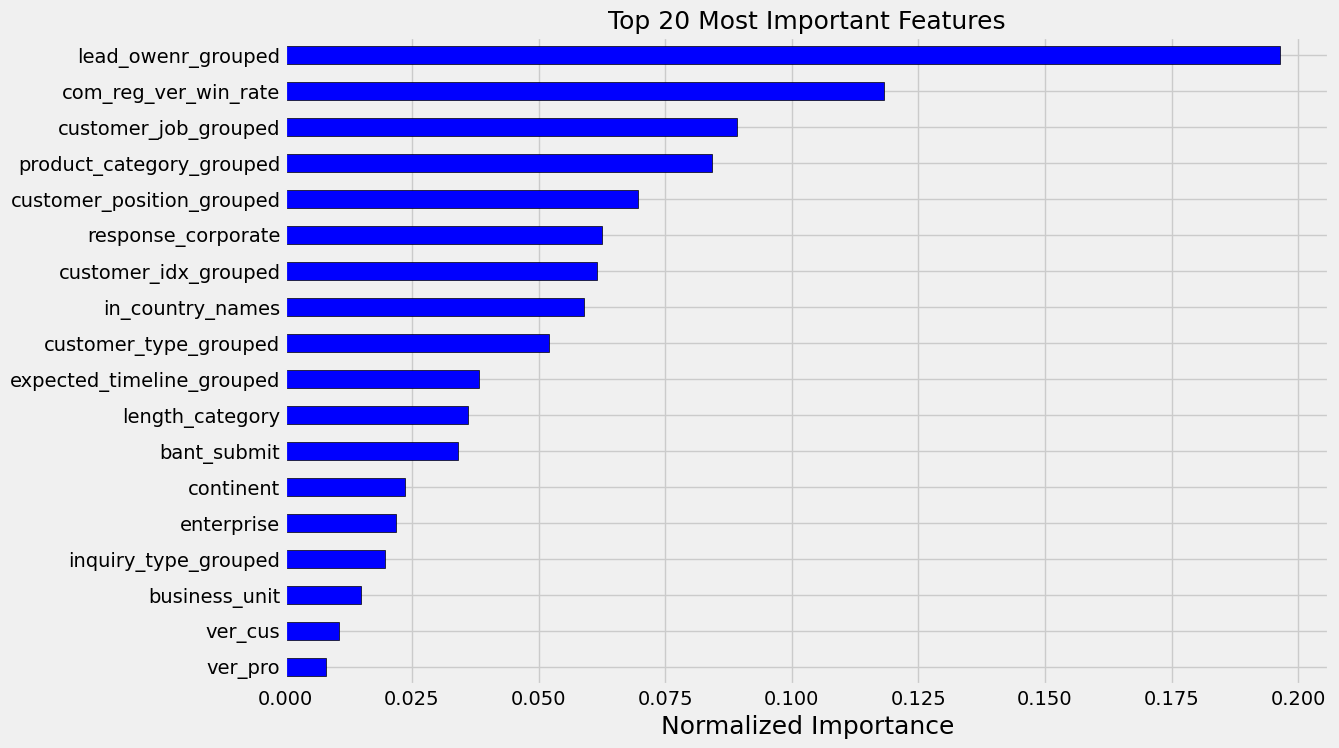

In [41]:
f1 = plot_feature_importances(f1)

In [77]:
train = train.drop(['ver_cus', 'ver_pro', 'business_unit'], axis = 1)
test = test.drop(['ver_cus', 'ver_pro', 'business_unit'], axis = 1)